In [1]:
import pandas as pd

# Reading the data

In [2]:
df = pd.read_csv("income_data.csv")

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [4]:
cat_columns = ['sex', 'education', 'race']
cont_columns = ['age', 'education-num', 'hours-per-week']
features = cat_columns + cont_columns
target = "target"

# Building the first pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [18]:
cat_trans = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
cont_trans = Pipeline(steps=[('scaler', StandardScaler())])

feat_trans = ColumnTransformer(
    transformers=[('categorical', cat_trans, cat_columns),
                  ('continuous', cont_trans, cont_columns)])

def mk_knn(k):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

def mk_tree(d):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', DecisionTreeClassifier(max_depth=d))
    ])

In [19]:
mk_tree(3)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

In [9]:
from sklearn import set_config

In [10]:
set_config(display='diagram')

In [11]:
mk_tree(3)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

# Model evaluation

In [13]:
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [36]:
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target], test_size=0.3)

In [37]:
ytr

14561    0
24786    0
18324    0
31352    0
28092    0
        ..
16491    0
5097     0
26291    0
11726    1
6330     1
Name: target, Length: 22792, dtype: int64

In [38]:
sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))

0.8039717473641109

## K-fold Cross-validation

In [39]:
from sklearn.model_selection import cross_val_score

In [47]:
cv_scores = cross_val_score(mk_tree(5), df[features], df[target], cv=30)

In [48]:
cv_scores

array([0.80847145, 0.78360958, 0.81123389, 0.81031308, 0.80294659,
       0.80110497, 0.81123389, 0.81767956, 0.82412523, 0.77900552,
       0.8038674 , 0.81382488, 0.80184332, 0.81751152, 0.80737327,
       0.81935484, 0.81658986, 0.79078341, 0.80737327, 0.80092166,
       0.81382488, 0.81751152, 0.82580645, 0.81751152, 0.80645161,
       0.81013825, 0.81474654, 0.80645161, 0.80552995, 0.79170507])

In [42]:
import numpy as np

In [49]:
bs_samples = pd.Series(
    cv_scores[np.random.randint(20, size=20)].mean() for _ in range(1000))

<AxesSubplot:ylabel='Frequency'>

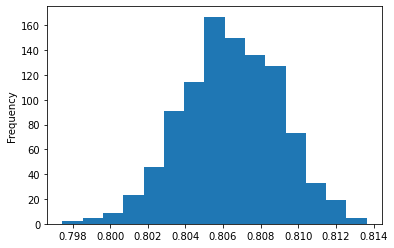

In [51]:
bs_samples.plot.hist(bins=15)

In [56]:
# look for good value for k in kNN model

def knn_score(k):
    return sklearn.metrics.accuracy_score(
        yte, mk_knn(k).fit(Xtr, ytr).predict(Xte)
    )

In [57]:
ks = range(5, 31, 5)

In [58]:
knn_scores = [knn_score(k) for k in ks]

<AxesSubplot:>

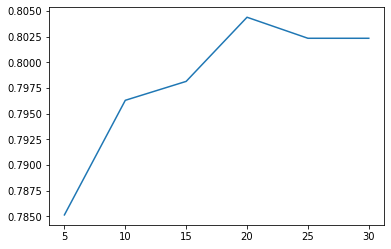

In [59]:
pd.Series(knn_scores, index=ks).plot.line()

## Using cross validation

In [60]:
ds = range(1, 15)

In [61]:
score_results = [cross_val_score(mk_tree(d), df[features], df[target], cv=5) for d in ds]

In [62]:
score_results

[array([0.75909719, 0.75921376, 0.75921376, 0.75921376, 0.75921376]),
 array([0.78120682, 0.78393735, 0.7882371 , 0.79038698, 0.78224816]),
 array([0.79594657, 0.80159705, 0.80451474, 0.80712531, 0.80175061]),
 array([0.8003992 , 0.80144349, 0.80727887, 0.80712531, 0.80451474]),
 array([0.80132044, 0.80651106, 0.8088145 , 0.81280713, 0.80558968]),
 array([0.8011669 , 0.80574324, 0.80835381, 0.81019656, 0.80528256]),
 array([0.80515891, 0.80712531, 0.8088145 , 0.81464988, 0.80681818]),
 array([0.80070628, 0.80605037, 0.80927518, 0.81096437, 0.80420762]),
 array([0.79932443, 0.80236486, 0.80927518, 0.80973587, 0.80359337]),
 array([0.79809612, 0.79914005, 0.80589681, 0.80820025, 0.80159705]),
 array([0.7968678 , 0.79898649, 0.80374693, 0.80405405, 0.8022113 ]),
 array([0.79118686, 0.79683661, 0.79929361, 0.80175061, 0.79699017]),
 array([0.78627361, 0.79284398, 0.79376536, 0.79683661, 0.79361179]),
 array([0.78243513, 0.79054054, 0.79376536, 0.79391892, 0.79437961])]

In [70]:
sr = pd.DataFrame(score_results, index=ds).T

In [71]:
sr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.759097,0.781207,0.795947,0.800399,0.801320,0.801167,0.805159,0.800706,0.799324,0.798096,0.796868,0.791187,0.786274,0.782435
1,0.759214,0.783937,0.801597,0.801443,0.806511,0.805743,0.807125,0.806050,0.802365,0.799140,0.798986,0.796837,0.792844,0.790541
2,0.759214,0.788237,0.804515,0.807279,0.808814,0.808354,0.808814,0.809275,0.809275,0.805897,0.803747,0.799294,0.793765,0.793765
3,0.759214,0.790387,0.807125,0.807125,0.812807,0.810197,0.814650,0.810964,0.809736,0.808200,0.804054,0.801751,0.796837,0.793919
4,0.759214,0.782248,0.801751,0.804515,0.805590,0.805283,0.806818,0.804208,0.803593,0.801597,0.802211,0.796990,0.793612,0.794380


<AxesSubplot:>

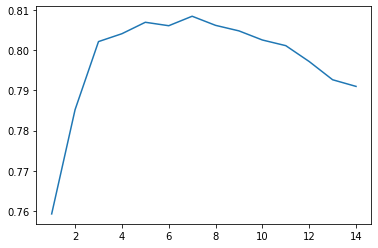

In [73]:
sr.mean().plot.line()

In [65]:
import matplotlib.pyplot as plt

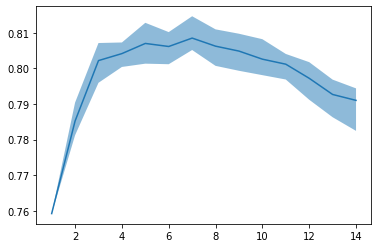

In [75]:
sr.mean().plot.line()
plt.fill_between(ds, sr.min(), sr.max(), alpha=0.5)

# Grid Search

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
param_grid = {'classifier__max_depth': ds}
grid_search = GridSearchCV(mk_tree(1), param_grid, cv=10)

In [78]:
fit_result = grid_search.fit(df[features], df[target])

In [80]:
fit_result.best_estimator_.get_params()

{'memory': None,
 'steps': [('feature_transform',
   ColumnTransformer(transformers=[('categorical',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['sex', 'education', 'race']),
                                   ('continuous',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['age', 'education-num', 'hours-per-week'])])),
  ('classifier', DecisionTreeClassifier(max_depth=7))],
 'verbose': False,
 'feature_transform': ColumnTransformer(transformers=[('categorical',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(drop='first'))]),
                                  ['sex', 'education', 'race']),
                                 ('continuous',
                                  Pipeline(steps=[('scaler', Sta

## Feature Selection

<AxesSubplot:xlabel='education'>

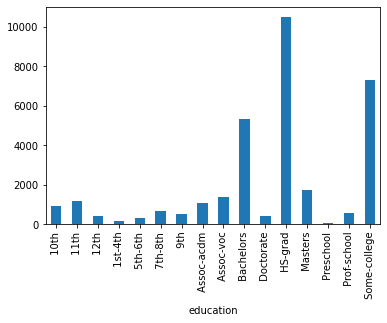

In [102]:
df.groupby('education').size().plot.bar()

In [82]:
dummies = pd.get_dummies(df[['occupation', 'education']])

## Variance cutoff

In [83]:
dummies.var()

occupation_ ?                    0.053399
occupation_ Adm-clerical         0.102380
occupation_ Armed-Forces         0.000276
occupation_ Craft-repair         0.110043
occupation_ Exec-managerial      0.109283
occupation_ Farming-fishing      0.029596
occupation_ Handlers-cleaners    0.040306
occupation_ Machine-op-inspct    0.057706
occupation_ Other-service        0.090957
occupation_ Priv-house-serv      0.004555
occupation_ Prof-specialty       0.110983
occupation_ Protective-serv      0.019535
occupation_ Sales                0.099535
occupation_ Tech-support         0.027689
occupation_ Transport-moving     0.046642
education_ 10th                  0.027834
education_ 11th                  0.034785
education_ 12th                  0.013122
education_ 1st-4th               0.005133
education_ 5th-6th               0.010123
education_ 7th-8th               0.019447
education_ 9th                   0.015537
education_ Assoc-acdm            0.031696
education_ Assoc-voc             0

In [84]:
from sklearn.feature_selection import VarianceThreshold

In [95]:
vt = VarianceThreshold(0.9*(1 - 0.9)).fit(dummies)

In [96]:
dummies.columns[vt.get_support()]

Index(['occupation_ Adm-clerical', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Other-service',
       'occupation_ Prof-specialty', 'occupation_ Sales',
       'education_ Bachelors', 'education_ HS-grad',
       'education_ Some-college'],
      dtype='object')

In [97]:
k = vt.get_support().sum()
k

9

## Univariate

In [98]:
from sklearn.feature_selection import SelectKBest

In [99]:
skb = SelectKBest(k=k).fit(dummies, df[target])

In [101]:
dummies.columns[skb.get_support()]

Index(['occupation_ Adm-clerical', 'occupation_ Exec-managerial',
       'occupation_ Other-service', 'occupation_ Prof-specialty',
       'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad',
       'education_ Masters', 'education_ Prof-school'],
      dtype='object')

## Sequential feature selection

In [103]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(DecisionTreeClassifier(max_depth=4), n_features_to_select=k)

In [104]:
sfs.fit(dummies, df[target])

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4),
                          n_features_to_select=9)

In [105]:
dummies.shape

(32561, 31)

In [106]:
dummies.columns[sfs.get_support()]

Index(['occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Priv-house-serv', 'occupation_ Sales',
       'education_ Doctorate', 'education_ Masters', 'education_ Prof-school'],
      dtype='object')

In [107]:
selectors = {
    'variance threshold': vt,
    'select k best': skb,
    'forward stepwise': sfs
}

In [108]:
classifier = DecisionTreeClassifier(max_depth=4)
s_scores = {k: cross_val_score(classifier, selectors[k].transform(dummies), df[target], cv=20) for k in selectors}

<AxesSubplot:>

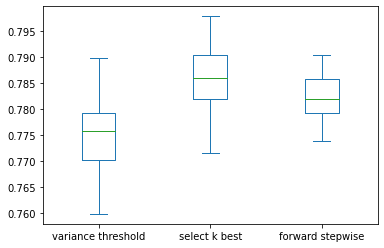

In [110]:
pd.DataFrame(s_scores).plot.box()